In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F30764%2F39238%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240410%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240410T080531Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D755b78983fdadf6fbd7d7018c2e9750400522c38c690e59f2e277574e78ffa45962a9fd146989df37aef2f973913b1b5b0e6a56329ca657be35ba9d9eff7aa52cd303574d10f5c88df421d3e4b8695ed69c9baaa0389b175324320ceb45060df3c47b448436179d5f88f3673ffcccf85cc5cfc656225053a10980867470ff1d43e950714195013841aa2958e315f5a4c4caf8b6cbcb57e3648f6dc5718eb1a0e150260aa422e0d3a7ed9aac8a7d0e83f5bef92789439f4f925ec9970810e6dd9c36c558691cb0ccf4a6b514ca6d9a44de1c0dc1f775b8679a488581c3212f577d9457d3835291943fa255033a6302b0b373ed0ec1acda2f4808fd4f31879cc0a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
%matplotlib inline
import os
import re
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['Sarcasm_Headlines_Dataset.json']


# Data Pre-Processing
- Getting rid of unwanted data
- Checking up if the data is normalized or not
- Filtering Headlines
- Defining max features
- Vectorize & Convert text for input
- Splitting data to train & test

In [ ]:
df = pd.read_json('../input/Sarcasm_Headlines_Dataset.json', lines=True)
df.head()


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


- ### Getting rid of unwanted data

In [ ]:
df = df[['headline','is_sarcastic']]
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


- ### Checking for normalization

Text(0.5, 1.0, 'Sarcasm vs Non-sarcasm')

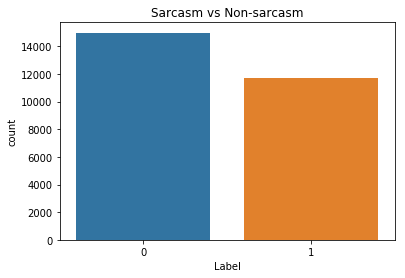

In [ ]:
sns.countplot(df.is_sarcastic)
plt.xlabel('Label')
plt.title('Sarcasm vs Non-sarcasm')


- ### Filtering headlines
- So that only valid headlines remain &

In [ ]:
df['headline'] = df['headline'].apply(lambda x: x.lower())
df['headline'] = df['headline'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))


- ### Defining Max features
- ### using Tokenizer to vectorize and convert text into Sequences
 so that the Network can deal with it as input

In [ ]:
for idx,row in df.iterrows():
    row[0] = row[0].replace('rt',' ')

max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['headline'].values)
X = tokenizer.texts_to_sequences(df['headline'].values)
X = pad_sequences(X)

### Splitting data to train & test

In [ ]:
Y = pd.get_dummies(df['is_sarcastic']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(17895, 29) (17895, 2)
(8814, 29) (8814, 2)


# Defining the LSTM RNN Model
With softmax activation

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


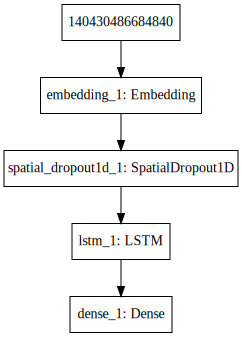

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

#### Training the model

In [ ]:
batch_size = 32
history = model.fit(X_train, Y_train, epochs = 25, batch_size=batch_size, verbose = 2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
 - 31s - loss: 0.4482 - acc: 0.7842
Epoch 2/25
 - 30s - loss: 0.3357 - acc: 0.8548
Epoch 3/25
 - 30s - loss: 0.3038 - acc: 0.8699
Epoch 4/25
 - 29s - loss: 0.2749 - acc: 0.8856
Epoch 5/25
 - 30s - loss: 0.2548 - acc: 0.8929
Epoch 6/25
 - 29s - loss: 0.2361 - acc: 0.9020
Epoch 7/25
 - 29s - loss: 0.2210 - acc: 0.9072
Epoch 8/25
 - 30s - loss: 0.2020 - acc: 0.9167
Epoch 9/25
 - 29s - loss: 0.1878 - acc: 0.9206
Epoch 10/25
 - 29s - loss: 0.1760 - acc: 0.9282
Epoch 11/25
 - 30s - loss: 0.1620 - acc: 0.9341
Epoch 12/25
 - 29s - loss: 0.1462 - acc: 0.9408
Epoch 13/25
 - 30s - loss: 0.1327 - acc: 0.9450
Epoch 14/25
 - 30s - loss: 0.1224 - acc: 0.9507
Epoch 15/25
 - 29s - loss: 0.1108 - acc: 0.9551
Epoch 16/25
 - 30s - loss: 0.1060 - acc: 0.9569
Epoch 17/25
 - 29s - loss: 0.0937 - acc: 0.9611
Epoch 18/25
 - 29s - loss: 0.0869 - acc: 0.9659
Epoch 19/25
 - 30s - loss: 0.0840 - acc: 0.9669
Epoch 20/25
 - 29s - loss: 0.0737 - acc: 0.9713
E

Let's check the accuracy and score now

In [ ]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 1.00
acc: 0.81


### A graph of accuracy & Loss vs Epoch

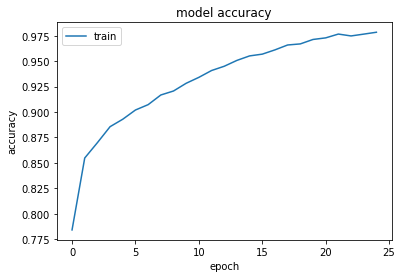

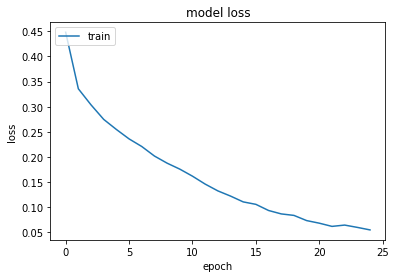

<Figure size 432x288 with 0 Axes>

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

#### Let's check it's score on sarcastic & non-sarcastic headlines respectively

In [ ]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):

    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]

    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1

    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("Sarcasm_acc", pos_correct/pos_cnt*100, "%")
print("Non-Sarcasm_acc", neg_correct/neg_cnt*100, "%")

Sarcasm_acc 80.69381598793363 %
Non-Sarcasm_acc 83.75149342891278 %


Pretty decent for a begginner huh?

Let me try it on a popular headline

In [ ]:
headline = ['Chowkidar hi chor hai']
headline = tokenizer.texts_to_sequences(headline)
headline = pad_sequences(headline, maxlen=29, dtype='int32', value=0)

sentiment = model.predict(headline,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("Non-sarcastic")
elif (np.argmax(sentiment) == 1):
    print("Sarcasm")

Sarcasm


In [ ]:
#Save the model
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")